<img src="Title.JPG">

# OverView 

<img src="Overview.JPG">

<img src="TimeLoss.JPG" style="margin:auto;">

<img src="ConsistencyLoss.JPG"  style="margin:auto;">
<br>
<br>
<br>

# SleepEEG => Epilepsy

In [2]:
import os
import numpy as np
from datetime import datetime
import argparse
from utils import _logger
from model import *
from dataloader import data_generator
from trainer import Trainer


# Args selections
start_time = datetime.now()
parser = argparse.ArgumentParser()
######################## Model parameters ########################
home_dir = os.getcwd()
parser.add_argument('--run_description', default='run1', type=str,
                    help='Experiment Description')
parser.add_argument('--seed', default=42, type=int, help='seed value')

# 1. self_supervised pre_train; 2. finetune (itself contains finetune and test)
parser.add_argument('--training_mode', default='fine_tune_test', type=str,
                    help='pre_train, fine_tune_test')

parser.add_argument('--pretrain_dataset', default='SleepEEG', type=str,
                    help='Dataset of choice: SleepEEG, FD_A, HAR, ECG')

parser.add_argument('--target_dataset', default='Epilepsy', type=str,
                    help='Dataset of choice: Epilepsy, FD_B, Gesture, EMG')

parser.add_argument('--logs_save_dir', default='../experiments_logs', type=str,
                    help='saving directory')
parser.add_argument('--device', default='cuda', type=str,
                    help='cpu or cuda')
parser.add_argument('--home_path', default=home_dir, type=str,
                    help='Project home directory')
args, unknown = parser.parse_known_args()

with_gpu = torch.cuda.is_available()
if with_gpu:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('We are using %s now.' %device)

pretrain_dataset = args.pretrain_dataset
targetdata = args.target_dataset
experiment_description = str(pretrain_dataset) + '_2_' + str(targetdata)


method = 'TF-C'
training_mode = args.training_mode
run_description = args.run_description
logs_save_dir = args.logs_save_dir
os.makedirs(logs_save_dir, exist_ok=True)
exec(f'from config_files.{pretrain_dataset}_Configs import Config as Configs')
configs = Configs()
configs.num_epoch = 300
SEED = args.seed
#torch.manual_seed(SEED)
#torch.backends.cudnn.deterministic = False
#torch.backends.cudnn.benchmark = False
#np.random.seed(SEED)
#####################################################

experiment_log_dir = os.path.join(logs_save_dir, experiment_description, run_description, training_mode + f"_seed_{SEED}_2layertransformer")
# 'experiments_logs/Exp1/run1/train_linear_seed_0'
os.makedirs(experiment_log_dir, exist_ok=True)

# loop through domains
counter = 0
src_counter = 0


# Logging
log_file_name = os.path.join(experiment_log_dir, f"logs_{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}.log")
# 'experiments_logs/Exp1/run1/train_linear_seed_0/logs_14_04_2022_15_13_12.log'
logger = _logger(log_file_name)
logger.debug("=" * 45)
logger.debug(f'Pre-training Dataset: {pretrain_dataset}')
logger.debug(f'Target (fine-tuning) Dataset: {targetdata}')
logger.debug(f'Method:  {method}')
logger.debug(f'Mode:    {training_mode}')
logger.debug("=" * 45)

# Load datasets
sourcedata_path = f"../../datasets/{pretrain_dataset}"
targetdata_path = f"../../datasets/{targetdata}"
subset = False  # if subset= true, use a subset for debugging.
train_dl, valid_dl, test_dl = data_generator(sourcedata_path, targetdata_path, configs, training_mode, subset = subset)
logger.debug("Data loaded ...")

# Load Model
"""Here are two models, one basemodel, another is temporal contrastive model"""
TFC_model = TFC(configs).to(device)
classifier = target_classifier(configs).to(device)
temporal_contr_model = None

'''
if training_mode == "fine_tune_test":
    # load saved model of this experiment
    load_from = os.path.join(os.path.join(logs_save_dir, experiment_description, run_description,
    f"pre_train_seed_{SEED}_2layertransformer", "saved_models"))
    print("The loading file path", load_from)
    #chkpoint = torch.load(os.path.join(load_from, "ckp_last.pt"), map_location=device)
    #pretrained_dict = chkpoint["model_state_dict"]
    #TFC_model.load_state_dict(pretrained_dict)
'''
model_optimizer = torch.optim.Adam(TFC_model.parameters(), lr=0.001, betas=(configs.beta1, configs.beta2), weight_decay=1e-6)
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, betas=(configs.beta1, configs.beta2), weight_decay=1e-6)


# Trainer
Trainer(TFC_model, model_optimizer, classifier, classifier_optimizer, train_dl, valid_dl, test_dl, device,
        logger, configs, experiment_log_dir, training_mode)

logger.debug(f"Training time is : {datetime.now()-start_time}")


We are using cuda now.
Pre-training Dataset: SleepEEG
Target (fine-tuning) Dataset: Epilepsy
Method:  TF-C
Mode:    fine_tune_test
Data loaded ...
Training started ....
Fine-tune on Fine-tuning set

Epoch : 1
Loss_T: 5.702304840087891, Loss_F: 5.756607532501221, Loss_TF: 6.134273529052734, Loss_P: 0.6980879902839661
 Finetune: loss = 7.9783| Acc=38.3333 | Precision = 32.8151 | Recall = 38.3333 | F1 = 32.9508| AUROC=39.8889 | AUPRC = 43.4540
update fine-tuned model
Test on Target datasts test set
MLP Testing: Acc=80.9282| Precision = 89.2378 | Recall = 51.8475 | F1 = 48.2668 | AUROC= 47.9930 | AUPRC=62.0859
KNN Testing: Acc=0.8021| Precision = 0.4011 | Recall = 0.5000 | F1 = 0.4451 | AUROC= 0.5386 | AUPRC=0.5135

Epoch : 2
Loss_T: 5.711130619049072, Loss_F: 5.747143745422363, Loss_TF: 5.875276565551758, Loss_P: 0.6764436960220337
 Finetune: loss = 7.6975| Acc=76.6667 | Precision = 77.1493 | Recall = 76.6667 | F1 = 76.5625| AUROC=78.0556 | AUPRC = 80.7136
update fine-tuned model
Test on 

<img src='sleepepi.JPG'>

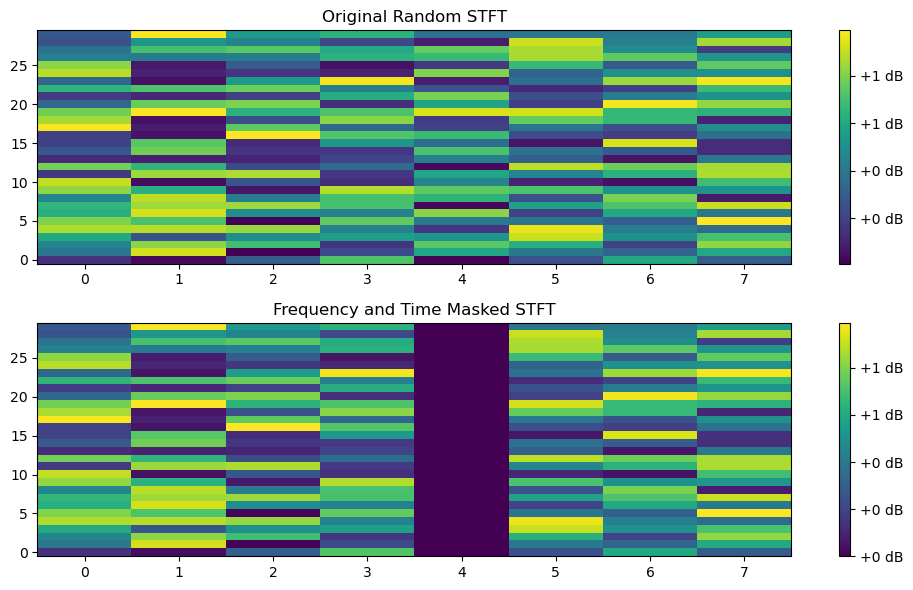

In [4]:
import numpy as np
import matplotlib.pyplot as plt


stft_size = (30, 8)
random_stft = np.random.rand(*stft_size)

def apply_frequency_masking(spec, freq_mask_param=4):
    spec = spec.copy()
    num_mel_channels = spec.shape[0]
    f = np.random.uniform(low=0.0, high=freq_mask_param)
    f0 = int(np.random.uniform(low=0.0, high=num_mel_channels - f))
    spec[f0:f0 + int(f)] = 0
    return spec

def apply_time_masking(spec, time_mask_param=2):
    spec = spec.copy()
    num_time_steps = spec.shape[1]
    t = np.random.uniform(low=0.0, high=time_mask_param)
    t0 = int(np.random.uniform(low=0.0, high=num_time_steps - t))
    spec[:, t0:t0 + int(t)] = 0
    return spec



freq_masked_spec = apply_frequency_masking(random_stft)
time_masked_spec = apply_time_masking(freq_masked_spec)

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.imshow(random_stft, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Random STFT')

plt.subplot(2, 1, 2)
plt.imshow(time_masked_spec, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Frequency and Time Masked STFT')

plt.tight_layout()
plt.show()


<br>
<h2 style="color:red;"> Time-Frequency Consistency</h2>

In [3]:
model_before = TFC(configs).to(device)

In [4]:
for batch_idx, (data, labels, aug1, data_f, aug1_f) in enumerate(train_dl):
    data = data.to('cuda')
    labels = data.to('cuda')
    aug1 = aug1.to('cuda')
    data_f = data_f.to('cuda')
    aug1_f = aug1_f.to('cuda')
    h_t, z_t, h_f, z_f = TFC_model(data, data_f)
    h_t_aug, z_t_aug, h_f_aug, z_f_aug = TFC_model(aug1, aug1_f)
    break

In [5]:
def compute_distances(a, b):
    cosine_similarity = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cosine_similarity

In [6]:
similarities = []
z_t = z_t.detach().cpu().numpy()
z_f = z_f.detach().cpu().numpy()
for i in range(len(z_t)):
    cosine_similarity = compute_distances(z_t[i], z_f[i])
    similarities.append(cosine_similarity)

In [7]:
for batch_idx, (data, labels, aug1, data_f, aug1_f) in enumerate(train_dl):
    data = data.to('cuda')
    labels = data.to('cuda')
    aug1 = aug1.to('cuda')
    data_f = data_f.to('cuda')
    aug1_f = aug1_f.to('cuda')
    h_t, z_t, h_f, z_f = model_before(data, data_f)
    h_t_aug, z_t_aug, h_f_aug, z_f_aug = model_before(aug1, aug1_f)
    break

In [8]:
similarities2 = []
z_t = z_t.detach().cpu().numpy()
z_f = z_f.detach().cpu().numpy()
for i in range(len(z_t)):
    cosine_similarity = compute_distances(z_t[i], z_f[i])
    similarities2.append(cosine_similarity)

### Original Model

Text(0.5, 1.0, 'Consistency')

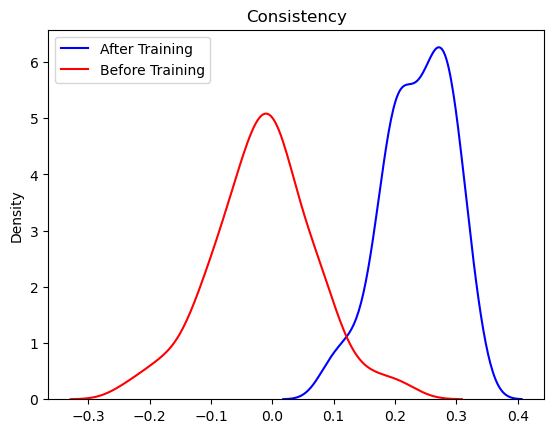

In [112]:
import seaborn as sns
sns.kdeplot(similarities, c='b')
sns.kdeplot(similarities2, c='r')
plt.legend(['After Training', 'Before Training'])
plt.title('Consistency')

### STFT Model

Text(0.5, 1.0, 'Consistency')

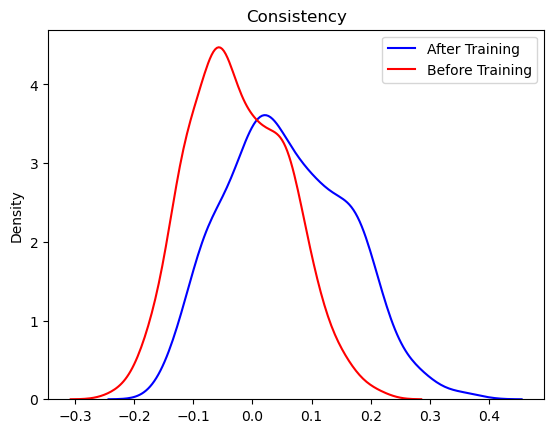

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(similarities, c='b')
sns.kdeplot(similarities2, c='r')
plt.legend(['After Training', 'Before Training'])
plt.title('Consistency')

<br>
<br>
<h2 style="color:red;"> Time-based Encoder (Gt) </h2>

In [10]:
for batch_idx, (data, labels, aug1, data_f, aug1_f) in enumerate(train_dl):
    data = data.to('cuda')
    labels = data.to('cuda')
    aug1 = aug1.to('cuda').type(torch.float32)
    data_f = data_f.to('cuda')
    aug1_f = aug1_f.to('cuda').type(torch.float32)
    h_t, z_t, h_f, z_f = model_before(data, data_f)
    h_t_aug, z_t_aug, h_f_aug, z_f_aug = model_before(aug1, aug1_f)
    break

In [11]:
similarities = []
h_t = h_t.detach().cpu().numpy()
h_t_aug = h_t_aug.detach().cpu().numpy()
for i in range(len(h_t_aug)):
    cosine_similarity = compute_distances(h_t[i], h_t_aug[i])
    similarities.append(cosine_similarity)

In [12]:
for batch_idx, (data, labels, aug1, data_f, aug1_f) in enumerate(train_dl):
    data = data.to('cuda')
    labels = data.to('cuda')
    aug1 = aug1.to('cuda').type(torch.float32)
    data_f = data_f.to('cuda')
    aug1_f = aug1_f.to('cuda').type(torch.float32)
    h_t, z_t, h_f, z_f = TFC_model(data, data_f)
    h_t_aug, z_t_aug, h_f_aug, z_f_aug = TFC_model(aug1, aug1_f)
    if batch_idx == 3:
        break

In [13]:
similarities2 = []
h_t = h_t.detach().cpu().numpy()
h_t_aug = h_t_aug.detach().cpu().numpy()
for i in range(len(h_t_aug)):
    cosine_similarity = compute_distances(h_t[i], h_t_aug[i])
    similarities2.append(cosine_similarity)

Text(0.5, 1.0, 'Time-based Contrastive Encoder')

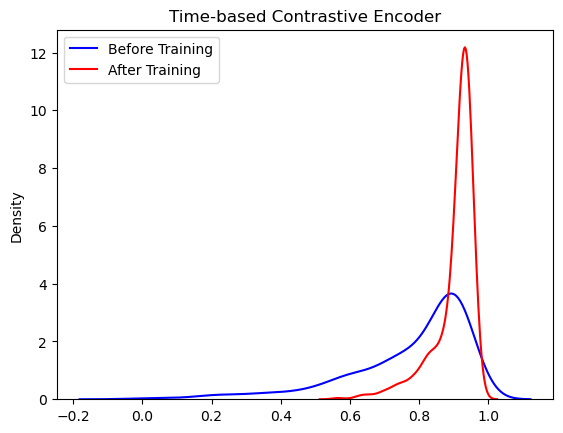

In [173]:
sns.kdeplot(similarities, c='b')
sns.kdeplot(similarities2, c='r')
plt.legend(['Before Training', 'After Training'])
plt.title('Time-based Contrastive Encoder')

<br>
<br>
<h2 style="color:red;"> Frequency(STFT)-based Encoder (Gf) </h2>

In [15]:
for batch_idx, (data, labels, aug1, data_f, aug1_f) in enumerate(train_dl):
    data = data.to('cuda')
    labels = data.to('cuda')
    aug1 = aug1.to('cuda').type(torch.float32)
    data_f = data_f.to('cuda')
    aug1_f = aug1_f.to('cuda').type(torch.float32)
    h_t, z_t, h_f, z_f = model_before(data, data_f)
    h_t_aug, z_t_aug, h_f_aug, z_f_aug = model_before(aug1, aug1_f)
    break

In [16]:
similarities = []
h_f = h_f.detach().cpu().numpy()
h_f_aug = h_f_aug.detach().cpu().numpy()
for i in range(len(h_f_aug)):
    cosine_similarity = compute_distances(h_f[i], h_f_aug[i])
    similarities.append(cosine_similarity)

In [17]:
for batch_idx, (data, labels, aug1, data_f, aug1_f) in enumerate(train_dl):
    data = data.to('cuda')
    labels = data.to('cuda')
    aug1 = aug1.to('cuda').type(torch.float32)
    data_f = data_f.to('cuda')
    aug1_f = aug1_f.to('cuda').type(torch.float32)
    h_t, z_t, h_f, z_f = TFC_model(data, data_f)
    h_t_aug, z_t_aug, h_f_aug, z_f_aug = TFC_model(aug1, aug1_f)

In [18]:
similarities2 = []
h_f = h_f.detach().cpu().numpy()
h_f_aug = h_f_aug.detach().cpu().numpy()
for i in range(len(h_f_aug)):
    cosine_similarity = compute_distances(h_f[i], h_f_aug[i])
    similarities2.append(cosine_similarity)

Text(0.5, 1.0, 'Frequency-based Contrastive Encoder')

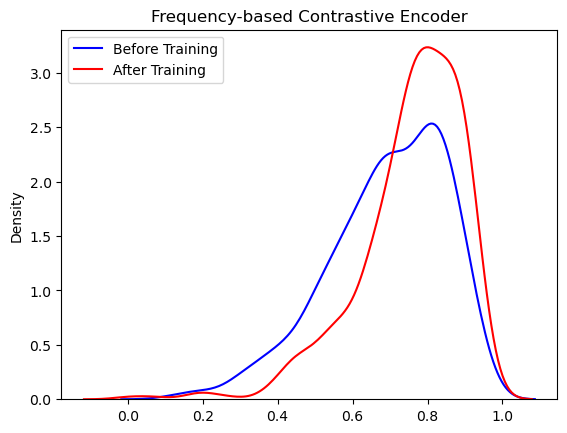

In [179]:
sns.kdeplot(similarities, c='b')
sns.kdeplot(similarities2, c='r')
plt.legend(['Before Training', 'After Training'])
plt.title('Frequency-based Contrastive Encoder')

Text(0.5, 1.0, 'STFT-based Contrastive Encoder')

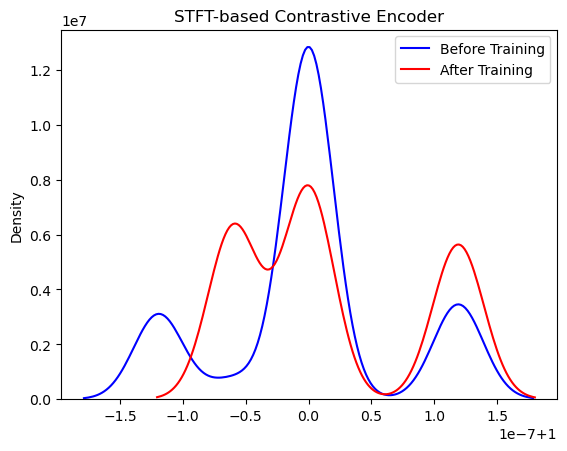

In [19]:
sns.kdeplot(similarities, c='b')
sns.kdeplot(similarities2, c='r')
plt.legend(['Before Training', 'After Training'])
plt.title('STFT-based Contrastive Encoder')

<br>
<br>
<h2 style="color:red;"> Fine-tuning - Epilepsy </h2>

In [6]:
test = torch.load('C:\\Users\\m.afshari\\Contrastive Learning\\datasets\\Epilepsy\\test.pt')

In [7]:
from dataloader import compute_stft_librosa
data = test['samples']
stft = []
for i in range(len(data)):
    st = compute_stft_librosa(data[i][0].numpy(),  100, 50, 25, 0.5, 30.0, 100)
    st = torch.tensor(st)
    stft.append(st)
stft = torch.stack(stft, dim = 0)
stft = stft.unsqueeze(1)
data_f = stft
labels = test['labels']

In [22]:
h_t, z_t, h_f, z_f = TFC_model(data.type(torch.float32).to('cuda'), data_f.type(torch.float32).to('cuda'))

In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
emb = tsne.fit_transform(z_t.detach().cpu().numpy())

In [36]:
import pandas as pd
df = pd.DataFrame(emb, columns=['x','y'])
df['label'] = labels[:len(emb)]
df

,x,y,label
0,-27.360378,54.639160,0
1,45.237354,42.240097,0
2,44.262909,31.503305,0
3,66.142395,5.780647,0
4,77.476662,26.695257,0
...,...,...,...
11415,68.818687,28.421871,1
11416,2.057463,-23.433350,1
11417,17.167112,-11.232009,1
11418,17.044554,4.781257,1


Text(0.5, 1.0, 'Time-based Embeddings - TSNE - Healthy / Epilepsy')

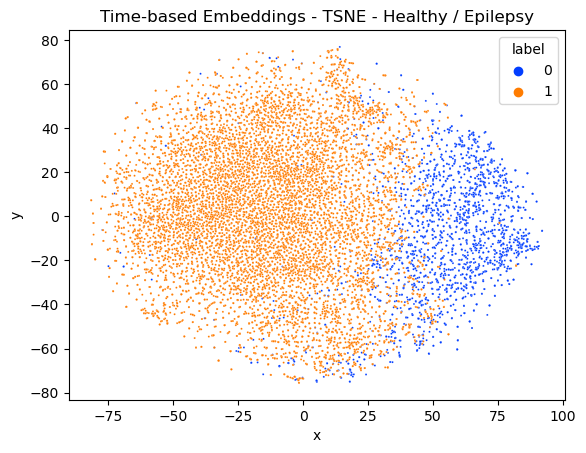

In [236]:
import matplotlib.pyplot as plt

sns.scatterplot(data=df,x='x',y='y', hue='label', palette = "bright", s=2)
plt.title('Time-based Embeddings - TSNE - Healthy / Epilepsy')

Text(0.5, 1.0, 'Time-based Embeddings - TSNE - Healthy / Epilepsy')

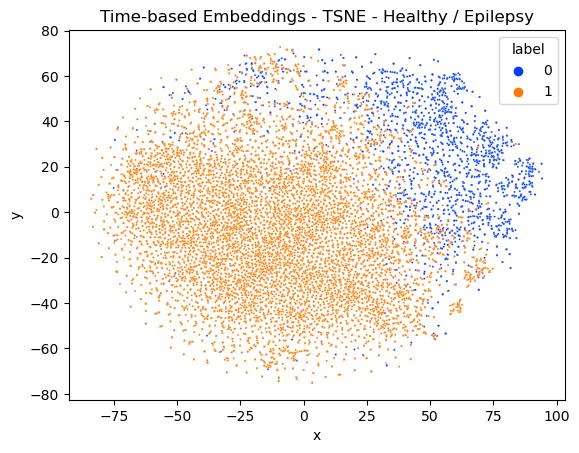

In [37]:
import matplotlib.pyplot as plt

sns.scatterplot(data=df,x='x',y='y', hue='label', palette = "bright", s=2)
plt.title('Time-based Embeddings - TSNE - Healthy / Epilepsy')

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
emb = tsne.fit_transform(z_f.detach().cpu().numpy())

In [24]:
import pandas as pd
df = pd.DataFrame(emb, columns=['x','y'])
df['label'] = labels[:len(emb)]
df

,x,y,label
0,-23.002996,-48.108437,0
1,4.261643,-53.548256,0
2,13.429479,18.378727,0
3,11.011374,2.958203,0
4,-21.574553,7.979725,0
...,...,...,...
11415,58.874474,-27.216616,1
11416,-31.937943,58.908607,1
11417,-51.332436,-18.310997,1
11418,-43.904572,51.272411,1


Text(0.5, 1.0, 'Frequency-based Embeddings - TSNE - Healthy / Epilepsy')

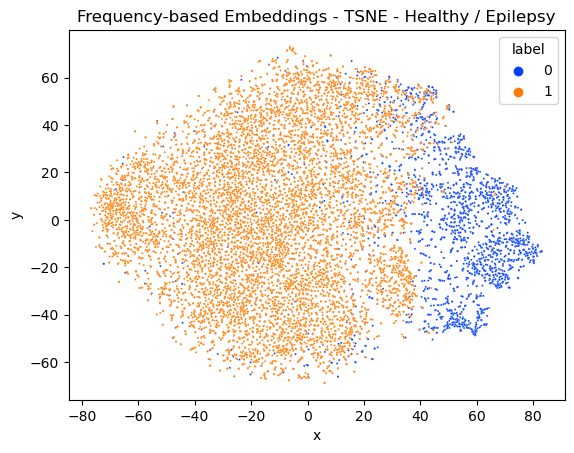

In [239]:
import matplotlib.pyplot as plt

sns.scatterplot(data=df,x='x',y='y', hue='label', palette = "bright", s=2)
plt.title('Frequency-based Embeddings - TSNE - Healthy / Epilepsy')

Text(0.5, 1.0, 'STFT-based Embeddings - TSNE - Healthy / Epilepsy')

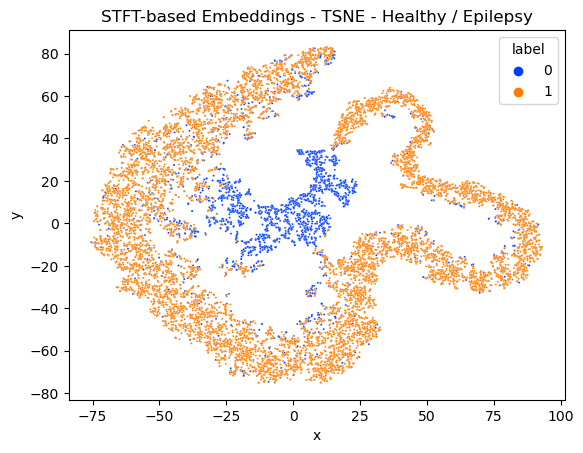

In [25]:
import matplotlib.pyplot as plt

sns.scatterplot(data=df,x='x',y='y', hue='label', palette = "bright", s=2)
plt.title('STFT-based Embeddings - TSNE - Healthy / Epilepsy')

In [1]:
import os
import numpy as np
from datetime import datetime
import argparse
from utils import _logger
from model import *
from dataloader import data_generator
from trainer import Trainer
import warnings
warnings.filterwarnings("ignore")

In [2]:
parser = argparse.ArgumentParser()
######################## Model parameters ########################
home_dir = os.getcwd()
parser.add_argument('--run_description', default='run1', type=str,
                    help='Experiment Description')
parser.add_argument('--seed', default=42, type=int, help='seed value')

# 1. self_supervised pre_train; 2. finetune (itself contains finetune and test)
parser.add_argument('--training_mode', default='fine_tune_test', type=str,
                    help='pre_train, fine_tune_test')

parser.add_argument('--pretrain_dataset', default='SleepEEG', type=str,
                    help='Dataset of choice: SleepEEG, FD_A, HAR, ECG')

parser.add_argument('--target_dataset', default='Epilepsy', type=str,
                    help='Dataset of choice: Epilepsy, FD_B, Gesture, EMG')

parser.add_argument('--logs_save_dir', default='../experiments_logs', type=str,
                    help='saving directory')
parser.add_argument('--device', default='cuda', type=str,
                    help='cpu or cuda')
parser.add_argument('--home_path', default=home_dir, type=str,
                    help='Project home directory')
args, unknown = parser.parse_known_args()

with_gpu = torch.cuda.is_available()

device = torch.device("cpu")
print('We are using %s now.' %device)

pretrain_dataset = args.pretrain_dataset
targetdata = args.target_dataset
experiment_description = str(pretrain_dataset) + '_2_' + str(targetdata)


method = 'TF-C'
training_mode = args.training_mode
run_description = args.run_description
logs_save_dir = args.logs_save_dir
os.makedirs(logs_save_dir, exist_ok=True)
exec(f'from config_files.{pretrain_dataset}_Configs import Config as Configs')

We are using cpu now.


In [3]:
configs = Configs()

In [4]:
before_model = TFC(configs).to('cpu')

In [8]:
h_t, z_t, h_f, z_f = before_model(data.type(torch.float32).to('cpu'), data_f.type(torch.float32).to('cpu'))

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
emb = tsne.fit_transform(z_t.detach().cpu().numpy())

In [10]:
import pandas as pd
df = pd.DataFrame(emb, columns=['x','y'])
df['label'] = labels[:len(emb)]
df

,x,y,label
0,-16.894176,14.152681,0
1,-22.699974,4.845121,0
2,11.516867,40.363964,0
3,-36.698215,14.185449,0
4,-27.385769,33.540646,0
...,...,...,...
11415,56.978092,-12.532601,1
11416,-6.922085,-21.190716,1
11417,-3.754643,9.462983,1
11418,-23.051535,18.175714,1


Text(0.5, 1.0, 'Time-based Embeddings - TSNE - Healthy / Epilepsy')

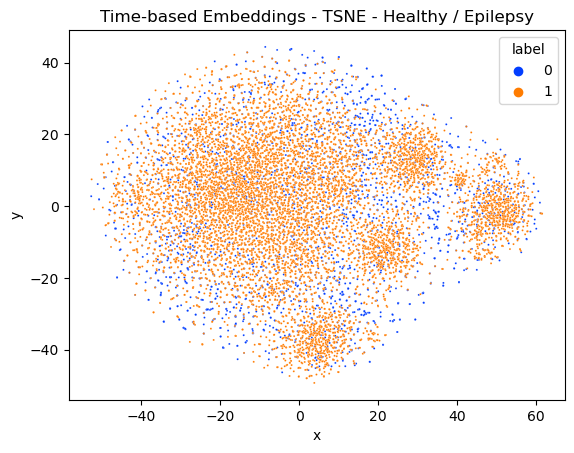

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(data=df,x='x',y='y', hue='label', palette = "bright", s=2)
plt.title('Time-based Embeddings - TSNE - Healthy / Epilepsy')

Text(0.5, 1.0, 'Time-based Embeddings - TSNE - Healthy / Epilepsy')

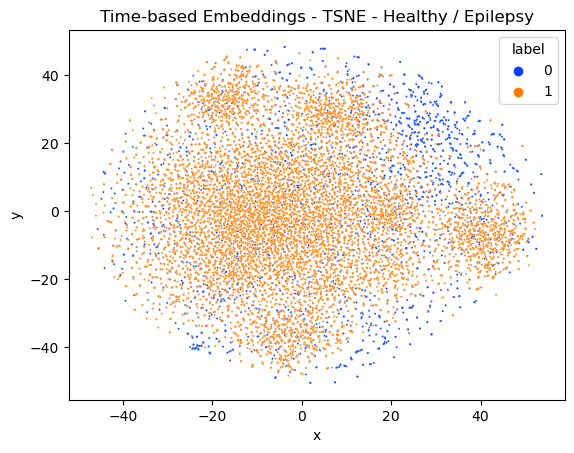

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(data=df,x='x',y='y', hue='label', palette = "bright", s=2)
plt.title('Time-based Embeddings - TSNE - Healthy / Epilepsy')

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
emb = tsne.fit_transform(z_f.detach().cpu().numpy())

In [12]:
import pandas as pd
df = pd.DataFrame(emb, columns=['x','y'])
df['label'] = labels[:len(emb)]
df

,x,y,label
0,-34.830265,-58.317478,0
1,-3.305552,-20.381620,0
2,-8.129143,13.131485,0
3,-18.057764,8.084207,0
4,16.828800,22.371363,0
...,...,...,...
11415,-39.936794,-5.119995,1
11416,50.805664,28.328238,1
11417,29.164068,-11.955230,1
11418,41.000229,10.918418,1


Text(0.5, 1.0, 'STFT Embeddings - TSNE - Healthy / Epilepsy')

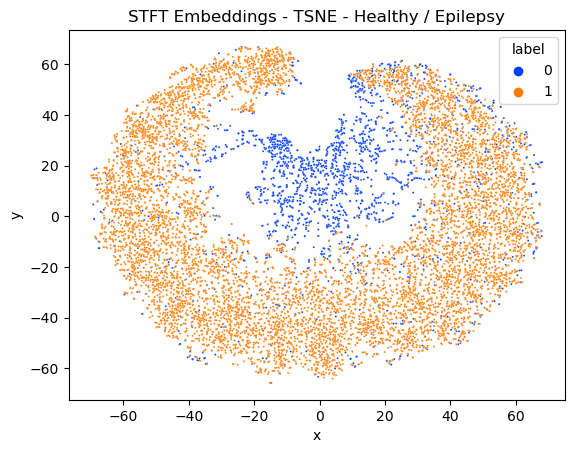

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(data=df,x='x',y='y', hue='label', palette = "bright", s=2)
plt.title('STFT Embeddings - TSNE - Healthy / Epilepsy')

<br>
<br>
<h2 style="color:red;"> Clustering </h2>

In [4]:
test = torch.load('C:\\Users\\m.afshari\\Contrastive Learning\\datasets\\Epilepsy\\test.pt')

In [23]:
data = test['samples']
labels = test['labels']

In [10]:
h_t, z_t, h_f, z_f = TFC_model(data.type(torch.float32).to('cuda'), data.type(torch.float32).to('cuda'))

In [16]:
import pandas as pd
data = pd.DataFrame(z_t.detach().cpu().numpy())

In [19]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)
from sklearn.model_selection import train_test_split

X = data
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

embeddings = X_test.values

silhouette = silhouette_score(embeddings, y_pred)
ari = adjusted_rand_score(y_test, y_pred)
nmi = normalized_mutual_info_score(y_test, y_pred)

print(f'Silhouette Score: {silhouette}')
print(f'Adjusted Rand Index: {ari}')
print(f'Normalized Mutual Information: {nmi}')

Silhouette Score: 0.5700365304946899
Adjusted Rand Index: 0.8199960920355085
Normalized Mutual Information: 0.7098267624933369


<img src="Cluster.JPG">